# 🛡️ Detecção de Intrusões em Sistemas de Energia Elétrica
## Competição com o Dataset ERENO-2.0-100K

In [2]:
# 1. Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2. Carregamento dos dados
df = pd.read_csv("data/ERENO-2.0-100K.csv")
df.columns = df.columns.str.strip()
df['class'] = df['class'].astype('category')
df = df.dropna(subset=['class'])
df.head()

,Time,isbA,isbB,isbC,vsbA,vsbB,vsbC,isbARmsValue,isbBRmsValue,isbCRmsValue,...,sqDiff,gooseLengthDiff,cbStatusDiff,apduSizeDiff,frameLengthDiff,timestampDiff,tDiff,timeFromLastChange,delay,class
0,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.005068,0.000000,0.022390,0.000130,grayhole
1,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022390,0.000130,normal
2,0.37464,0.029923,-0.076646,0.045858,-0.095898,0.055355,0.040523,0.048988,0.053399,0.052915,...,86.0,0.0,1.0,0.0,0.0,0.335783,97.634223,-97.276050,0.000123,injection
3,0.50337,0.432347,-0.113172,-0.138316,0.014902,0.082498,-0.079844,0.154143,0.057803,0.062056,...,-67.0,0.0,1.0,0.0,0.0,0.128662,6302.515166,-6399.662553,0.000055,high_StNum
4,0.7602,0.106018,-0.152017,0.015963,-0.070272,-0.022661,0.092251,0.110327,0.108409,0.071887,...,42.0,0.0,0.0,0.0,0.0,0.256906,519.062125,-6918.467772,0.000131,high_StNum


class
normal                    39999
masquerade_fake_fault     20000
high_StNum                20000
inverse_replay            20000
injection                 20000
poisoned_high_rate        20000
masquerade_fake_normal    20000
random_replay             20000
grayhole                  19999
Name: count, dtype: int64


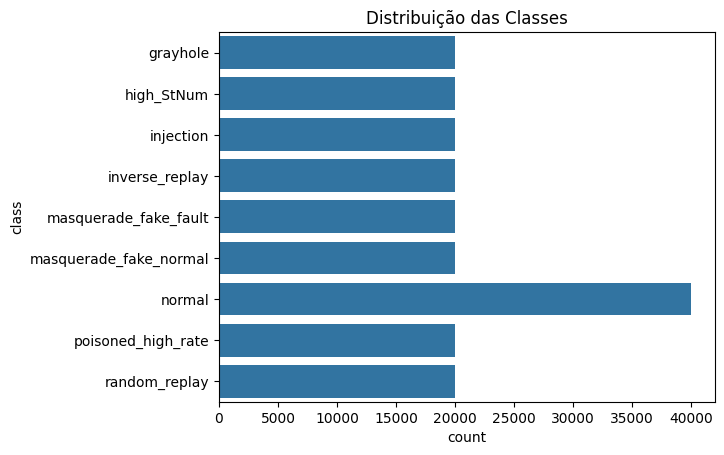

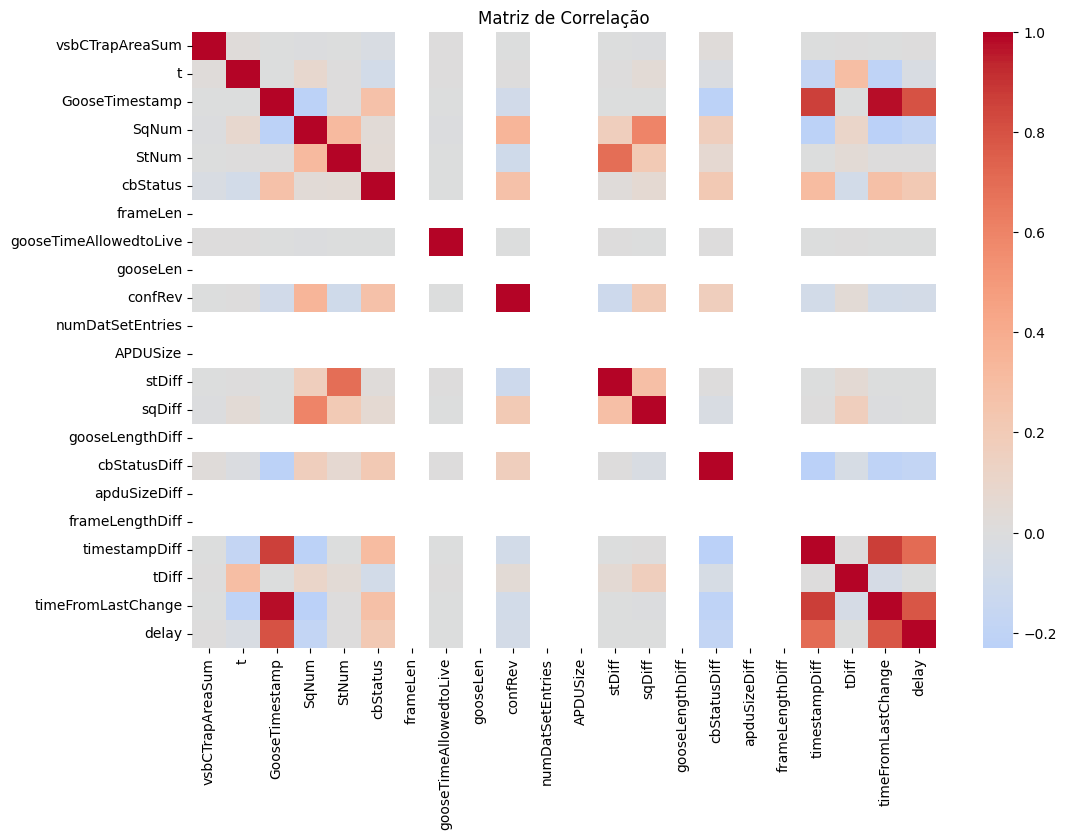

In [4]:
# 3. Análise exploratória
print(df['class'].value_counts())
sns.countplot(data=df, y='class')
plt.title("Distribuição das Classes")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', center=0)
plt.title("Matriz de Correlação")
plt.show()

In [5]:
# 4. Pré-processamento
drop_cols = ['ethDst', 'ethSrc', 'TPID', 'gocbRef', 'datSet', 'goID']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

df['test'] = df['test'].astype(str)
df['test'] = LabelEncoder().fit_transform(df['test'])

X = df.drop(columns=['class'])
y = df['class']

In [6]:
# 5. Divisão e normalização
# Garantir que todas as colunas sejam numéricas antes do scaler
X_clean = X.copy()

# Tenta converter tudo para numérico, e ignora o que não conseguir
for col in X_clean.columns:
    if X_clean[col].dtype == 'object':
        X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')

# Substitui valores não convertidos por 0 ou NaN
X_clean = X_clean.fillna(0)

# Divide
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3, stratify=y, random_state=42)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# 6. Treinamento do modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Acurácia:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.9246166666666666
[[ 3862     0     0     0     0     0  2115     0    23]
 [    0  5999     0     0     0     1     0     0     0]
 [    0     0  5997     1     1     1     0     0     0]
 [    0     0     0  5978     0     0     0     0    22]
 [    0     0     0     0  6000     0     0     0     0]
 [    0     0     0     0     3  5995     2     0     0]
 [ 1426     0     0     2     0     1 10480     0    91]
 [    0     0     0     0     0     0     0  5999     1]
 [    5     0     0     0     0    13   815     0  5167]]
                        precision    recall  f1-score   support

              grayhole       0.73      0.64      0.68      6000
            high_StNum       1.00      1.00      1.00      6000
             injection       1.00      1.00      1.00      6000
        inverse_replay       1.00      1.00      1.00      6000
 masquerade_fake_fault       1.00      1.00      1.00      6000
masquerade_fake_normal       1.00      1.00      1.00      6000
        

In [8]:
# 7. Ajuste de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'max_depth': None, 'n_estimators': 200}


 99%|===================| 1786/1800 [01:43<00:00]        

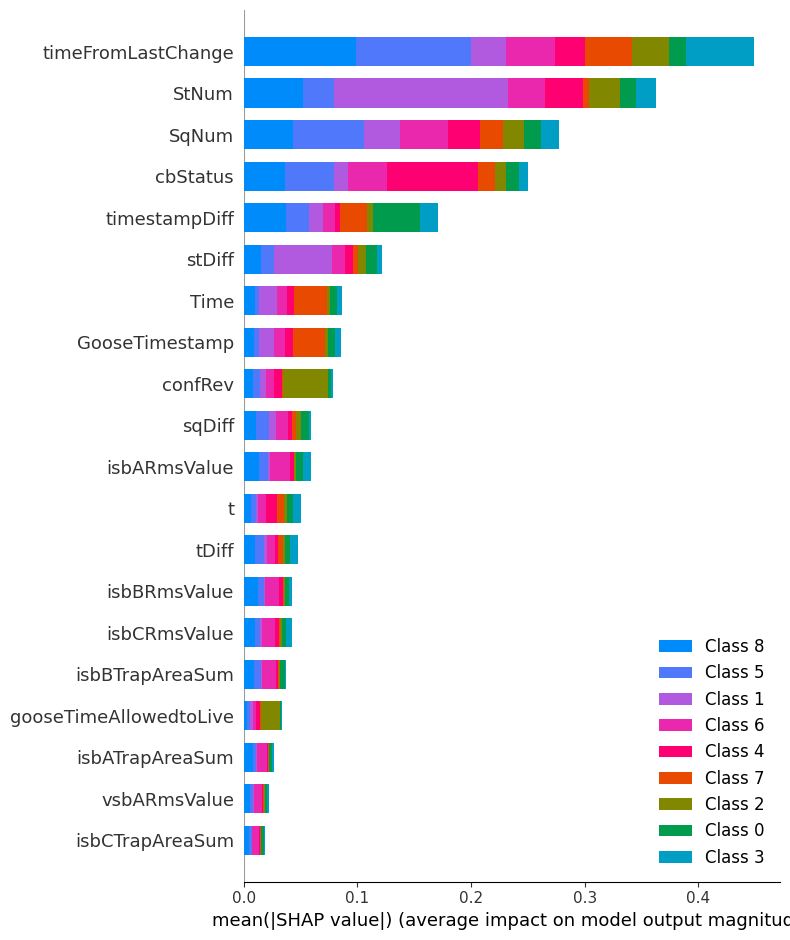

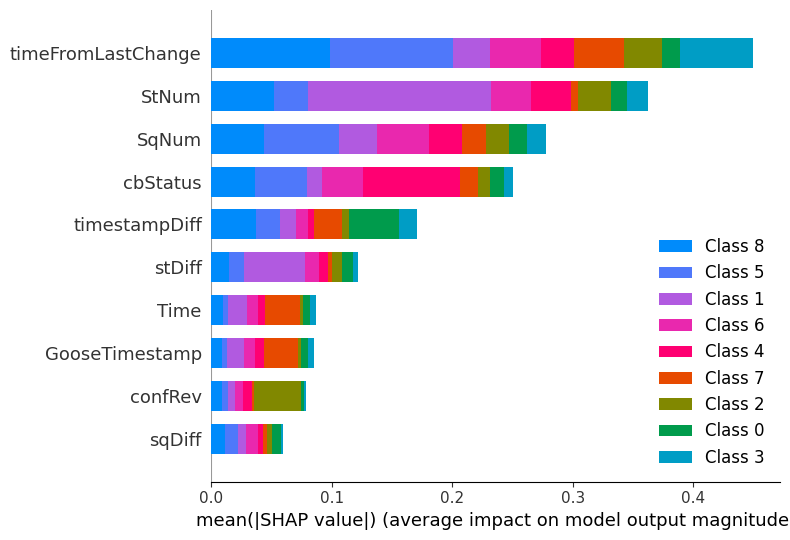

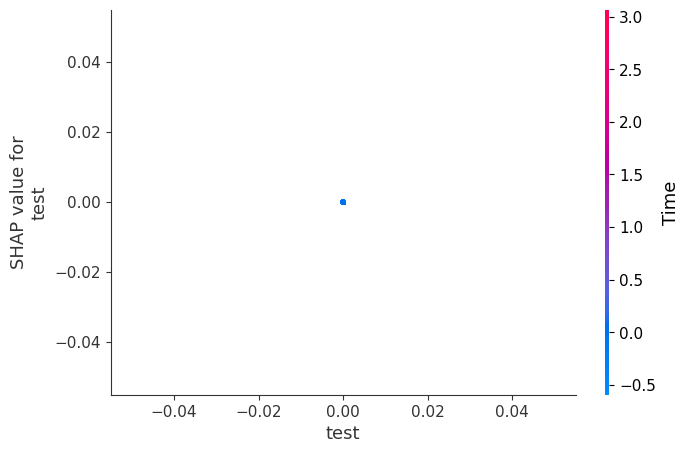

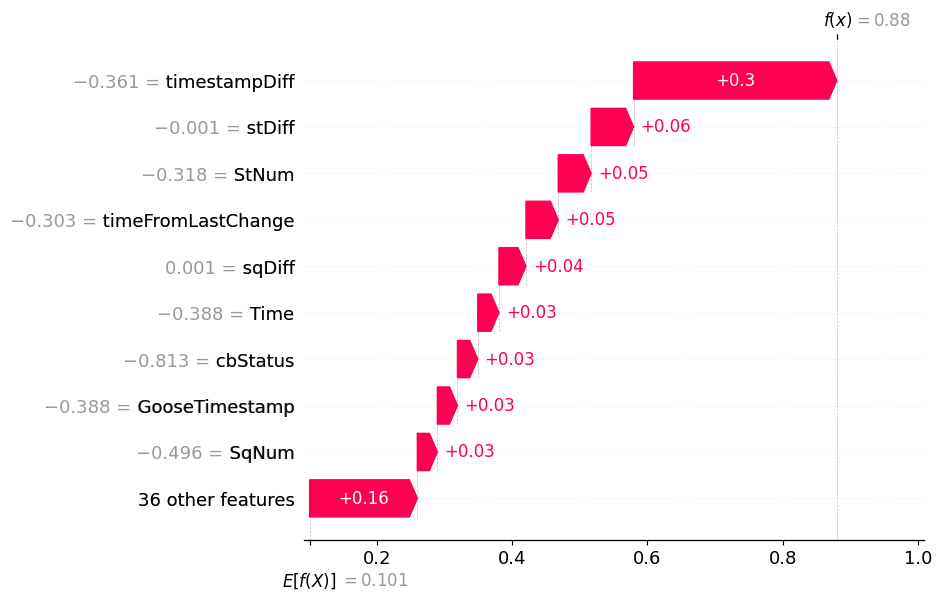

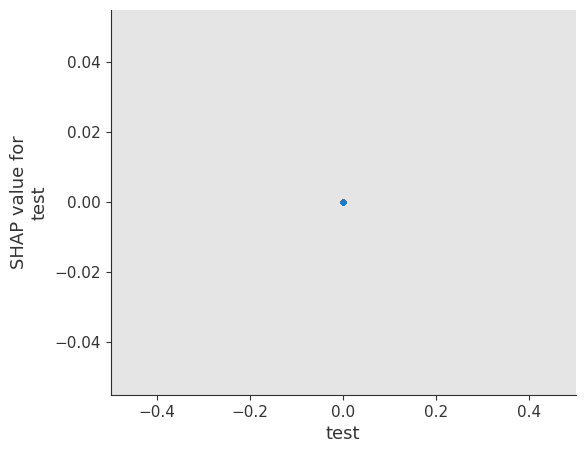

In [ ]:
# Explicabilidade com SHAP (amostra reduzida e mais rápida)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_sample = X_test_scaled_df.iloc[:200]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
shap.summary_plot(shap_values, X_sample, plot_type="dot", max_display=10)

# Dependence plot e waterfall para multiclasse ou binário
if hasattr(shap_values, "values") and shap_values.values.ndim == 3:
    # Multiclasse: escolha a classe 0 (ou outra)
    classe = 0
    shap.dependence_plot("test", shap_values.values[:, :, classe], X_sample, feature_names=X.columns)
    shap.plots.waterfall(shap_values[0, :, classe])
    shap.plots.scatter(shap_values[:, "test", classe])
else:
    shap.dependence_plot("test", shap_values.values, X_sample, feature_names=X.columns)
    shap.plots.waterfall(shap_values[0])
    shap.plots.scatter(shap_values[:, "test"])

Índices das classes:
0: grayhole
1: high_StNum
2: injection
3: inverse_replay
4: masquerade_fake_fault
5: masquerade_fake_normal
6: normal
7: poisoned_high_rate
8: random_replay


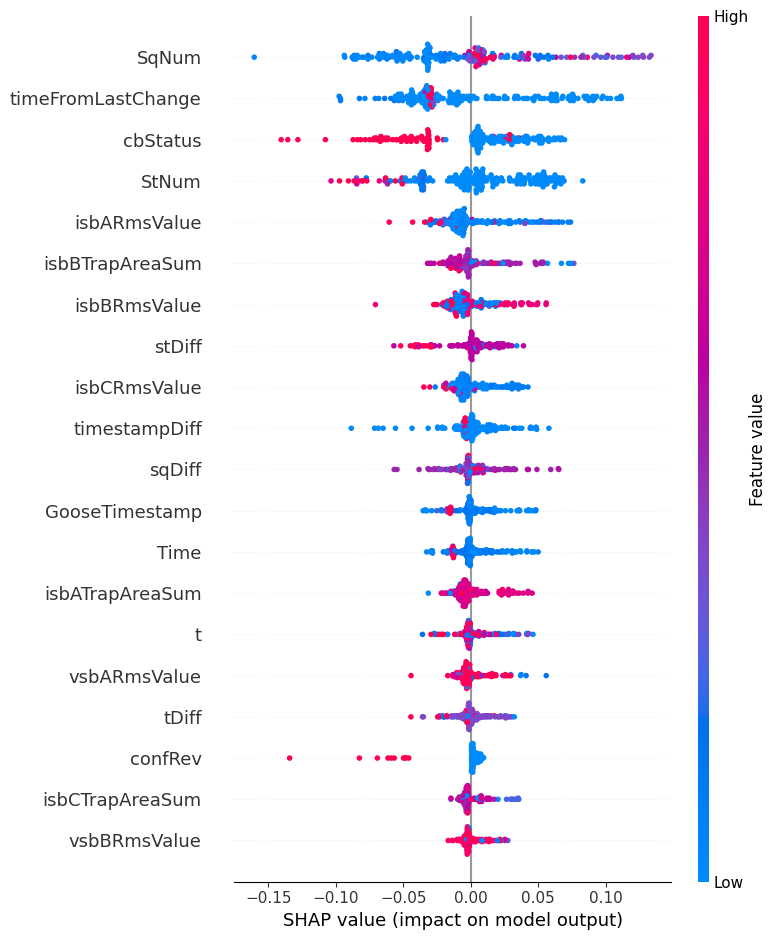

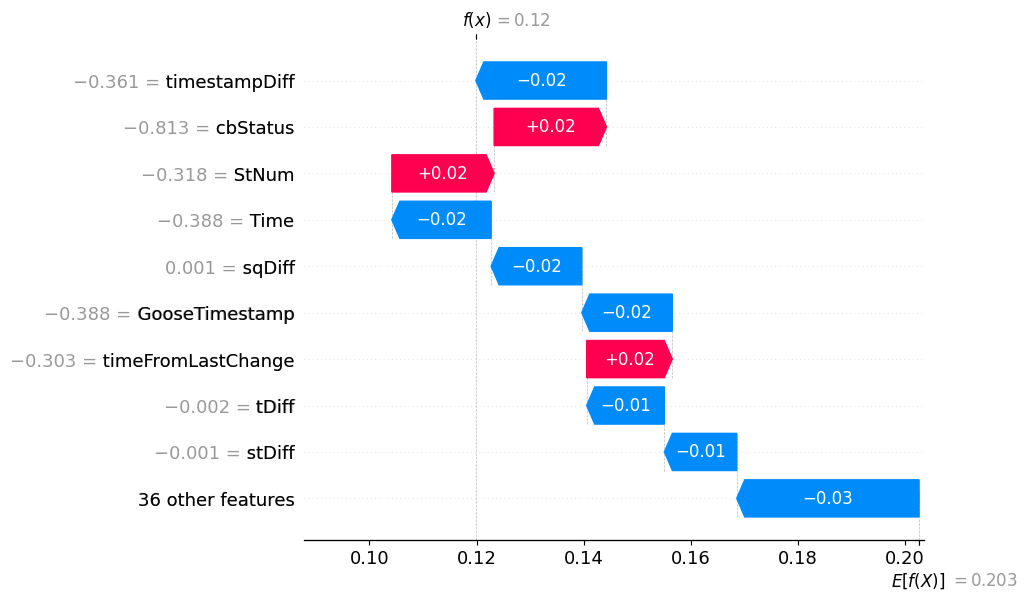

In [22]:
# Para multiclasse, escolha a classe (exemplo: classe 0)

print("Índices das classes:")
for idx, nome in enumerate(y.cat.categories):
    print(f"{idx}: {nome}")

classe = 6
shap.summary_plot(shap_values[:, :, classe], X_sample, plot_type="dot", feature_names=X.columns)
shap.plots.waterfall(shap_values[0, :, classe])